In [12]:
from encoder import Encoder
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import math
from matplotlib.patches import Ellipse
from scratch_builds.mog import MOG

Ideas for features:
- number of quotes in text
- grammar ratio (misspelled words / len of text)
- an TFIDF vector for each document (representing for all words in a vocabulary the TFIDF score for that particular document)
- an w2v vector for each document (representing for all words in a vocabulary the learned embedded vector for that particular document)

Dimensions for features:
- 1 integer
- 1 float
- a matrix with dimensions:  number_of_documents x words_in_vocab
- a matrix with dimensions: number_of_documents x (words_in_vocab x embedded_w2v_size)

Note: the last two can potentially get huge. Consider TFIDF vectors for the 10.000 most important words (according to that criterion)
Solution: Dimensionality reduction. I propose a MOG approach here. Example: TFIDF -> estimate (using cross-validation) an optimal
pdf using m weighted Gaussians of the data space: the cross product of all number_of_documents real vectors of dimenstionality vocab_size.
If m << dimensionality vocab_size -> profit.


 80%|████████  | 8/10 [00:00<00:00, 41.09it/s]Iteration: 0 Log-Likelihood: -625.3648961508228
Iteration: 1 Log-Likelihood: -222.80807432542588
Iteration: 2 Log-Likelihood: -215.13554840731132
Iteration: 3 Log-Likelihood: -213.97137262106037
Iteration: 4 Log-Likelihood: -213.29431398300125
Iteration: 5 Log-Likelihood: -212.77743908660318
Iteration: 6 Log-Likelihood: -212.3473447554379
Iteration: 7 Log-Likelihood: -211.9689794297678
Iteration: 8 Log-Likelihood: -211.61241264698748
Iteration: 9 Log-Likelihood: -211.25102129879465
100%|██████████| 10/10 [00:00<00:00, 40.97it/s]
Mean(s) : [[2.11327172]
 [3.37633216]] COV: [[0.84814471 0.17019129]
 [0.17019129 0.4112672 ]] Mean(s) : [[2.51623074]
 [2.82529008]] COV: [[0.27644985 0.05545253]
 [0.05545253 0.06373674]]


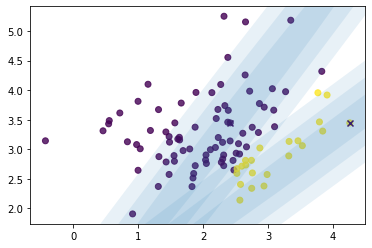

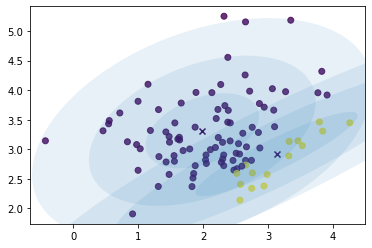

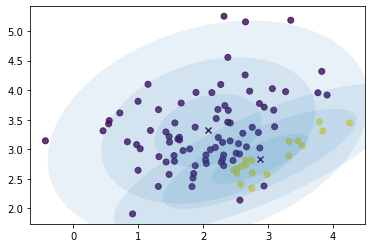

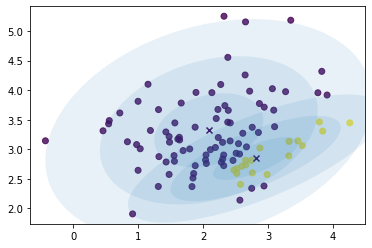

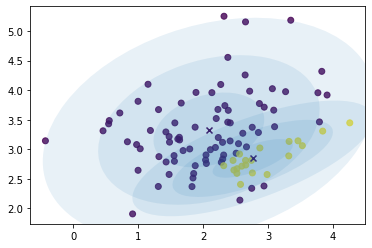

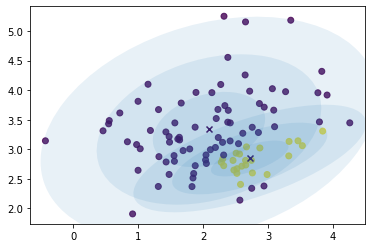

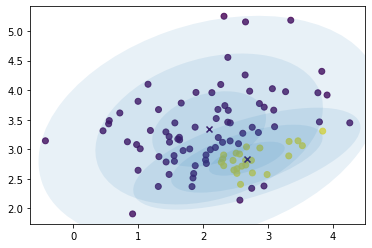

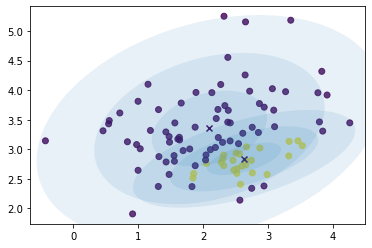

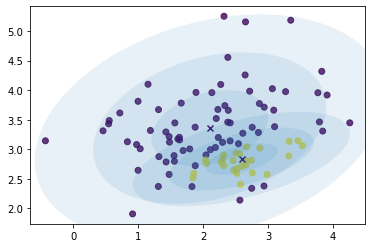

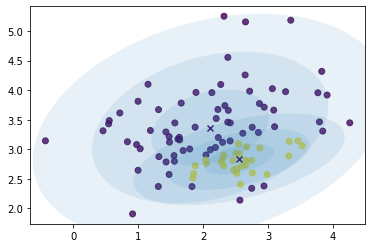

In [15]:
# Example of MOG:
if __name__ == "__main__":
    # Simulate (two weighted gaussians, so this is easy, but still it shows the idea.)
    X = []
    for i in range(100):
        cond = random.random()
        if cond > 0.7:
            X.append(np.random.multivariate_normal([3.0,4.0],[[0.45,0],[0,0.75]]).reshape(-1,1))
        else:
            X.append(np.random.multivariate_normal([2.0,3.0],[[0.65,0],[0,0.15]]).reshape(-1,1))
    X = np.array(X)
    mog = MOG(2,2)
    iterations = 10
    exp,means,covs = mog.fit(X,iterations)
    print(mog.gaussians[0],mog.gaussians[1])


    x = [d[0] for d in X]
    y = [d[1] for d in X]

    for expected, means_k, covs_k in zip(exp,means,covs):
        
        plt.scatter(x,y,c=expected,alpha=0.8)
        for index, mean_pair in enumerate(means_k):
            plt.scatter(mean_pair[0],mean_pair[1],c=index,marker="x")
        
        for index, (cov_k, mean_pair) in enumerate(zip(covs_k,means_k)):
            U, s, Vt = np.linalg.svd(cov_k)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * np.sqrt(s)
            for nsig in range(1, 4):
                plt.axes().add_artist(Ellipse(tuple(mean_pair), nsig * width, nsig * height,
                                    angle,alpha=0.1))

        plt.show()


In [3]:
# The features:
prob_matrix, log_likeli, member_expectation = mog.expectation(X)
print(prob_matrix[0]) # relative likelihood for first data point to belong to each of the gaussians.

[array([[0.99807908]]), array([[0.00192092]])]


In [13]:
# Now the real_deal:
train = "data/fake_news/fake_news/train.csv"
replacement_pairs = [['“','"'],['”','"'],
                        ['’',"'"],['—',"-"]]

### Encode ###
e = Encoder(train)
# This is the pre-processing step. What happens is that all punctuation is removed (after counting the
# number of quotes), a spell check is performed (and data excluded if it exceeds a cutoff) and the
# resulting grammar ratio is calculated. Our first two possible features, yay. Then, all sentences are
# transformed to lower case only and all stopwords are removed. Note, for w2v negative sampling would have
# penalized those words sufficiently anyway. However, for tf*idf we do not want them, like at all. Thus,
# they are dropped for good. Afterwards, if a document is shorter than a min len it is dropped as well.
# The cleaned, stopword removed, lower case letters are then converted back to
# nice strings and stored.
e.preprocess(replacement_pairs)


Pre-Processing:   0%|          | 0/20800 [00:00<?, ?it/s]   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  
Pre-Processing: 100%|██████████| 20800/20800 [01:32<00:00, 225.71it/s]Number of documents 

TFIDF-determined vocabulary size is: 501
[[0.         0.         0.1049851  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.06105671 0.         0.         ... 0.         0.         0.06715515]
 [0.17616075 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.12291099 ... 0.         0.         0.        ]]
Starting cross-validation
Model: 1 Flexibility score: 0 Train loss: -895.1166650635492 Test loss: -894.9872741938428


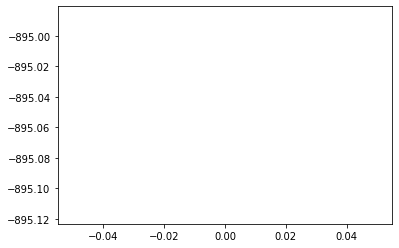

Model: 1 Flexibility score: 1 Train loss: -934.5787991712577 Test loss: -934.2841876062452


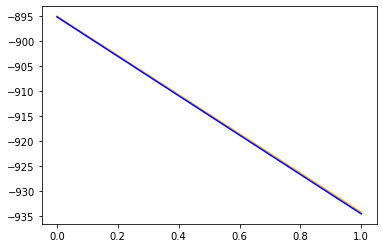

Model: 1 Flexibility score: 2 Train loss: -948.51269667959 Test loss: -947.7009082021234


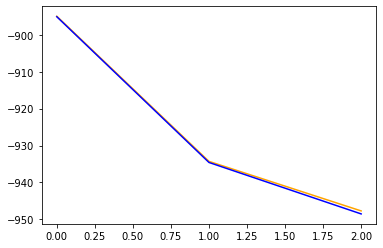

Model: 1 Flexibility score: 3 Train loss: -964.3746552583101 Test loss: -963.6446694419195


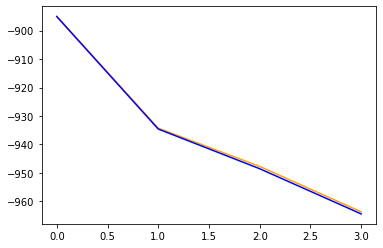

Model: 1 Flexibility score: 4 Train loss: -986.2645860171235 Test loss: -985.3419003727615


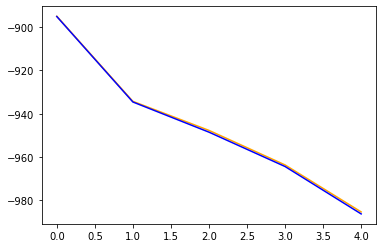

[[0.00000000e+000 2.76999887e-070 1.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00000000e+000 0.00000000e+000 0.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 7.88780246e-006 0.00000000e+000 9.99992112e-001
  0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 6.49302849e-046 0.00000000e+000 1.65846471e-025
  1.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.00158018e-086 7.07442391e-261 1.00000000e+000
  0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.67113258e-030 0.00000000e+000 1.00000000e+000
  0.00000000e+000 0.00000000e+000]]


In [16]:
# TF*IDF calculation

# Okay, now some fun stuff. We determine a max number of words that we want to keep from each document. Then
# the tf*IDF score is calculated for all words for each document: e.g. each document will be represented as a
# vector of the vocab size. Each element in this vector will correspond to the (log) tf*idf score of the word
# that corresponds to that particular index (the vocabulary matches integer values (indices) to words). If the
# word was not included in the document it will simply be a zero. Those vectors are then attached to a matrix
# for the entire corpus, e.g. the collection of all docs. There is a lot of other stuff happening here in preparation
# for W2V, if one wants to use that, but thats described in the function text.
e.tfidf_vectorize((1,1),max_features=500) # 500 for show-case

# Obviously having a feature vector of size 10.000 is a stupid idea if we have only 20.000 datapoints because the
# ratio of featurs/data will be huge. Since the vectors are like super sparse anyway, I thought why not try and
# represent each document by m scores, each representing the relative likelihood that the document is modelled by
# one of the m weighted gaussians used in the MOG. Specifically, if there are 4 gaussians we will get a vector for
# each document containing 4 relative likelihood values, each corresponding to one of the 4 gaussians.
# The idea: if we can reasonably cover the distribution of the data-space, similar documents should belong to
# similar gaussians.

# The method, if no target dimension reduction (e.g. number of gaussians) is specified, uses cross-validation to
# estimate the optimal number of gaussians (e.g. it adds gaussians until the likelihood of the test data does 
# decrease). Note: the plots below show the - log-likelihood since it wrote the CV function as a general minimizer. 
e.reduce_dim('vectorized',export="data/tfidf_reduced.csv",max_updates=5) # here only 5 updates for showcase.

In [17]:
# So feature matrix is now:
print(e.data["tfidf_reduced"][:5])

[[0.00000000e+00 2.76999887e-70 1.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.88780246e-06 0.00000000e+00 9.99992112e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.63798910e-83 0.00000000e+00 1.00000000e+00
  0.00000000e+00 6.61600152e-37]
 [0.00000000e+00 9.61961328e-56 0.00000000e+00 5.17272952e-28
  0.00000000e+00 1.00000000e+00]]


These three lines below fit a skip-gram W2V model using the training data. If you pick a max vocabulary size
in the first step the longest document has a length of ~ 12.000 after removing all words not in the
vocabulary created using TFIDF. Obviously trying to train the W2V model on this sequence length will
kill your pc. But I felt like having to reduce the size of each document to 100 would give away waaay too
much information. So I changed the W2V training: it now creates training data in-between and wipes the
memory clean after training on that data before creating new data... this is repeated until all documents
are processed once (one epoch). In theory this allows you to train on a max-len of 12.000 words in the longest document.
Using 75 documents to create one training data set generates between 4 and 5 million example points. Repeating this for
all 19.900 documents to complete one epoch takes weeks. So that might not be feasible. But you can fit on sequence
lengths between 500-1000 and use between 500-2000 documents as batch size (e.g. for which training data will be created).



In [20]:
# This first method removes from each document all words not in the TFIDF based vocabulary and if maxlen is specified it
# truncates all docs longer than the specified length and pads shorter ones with 0s ("''"). If you have done this padding step before
# (it takes a relatively long time) you can import the data for convenience. 
e.padd_shrink_documents(maxlen=50) # super short max len for presentation

Reducing document size: 100%|██████████| 19592/19592 [00:33<00:00, 585.77it/s]
Max document length was: 50
Some example padded vectors + conversions:
Vectorized padded : [189, 104, 126, 375, 301, 19, 320, 492, 106, 75] => ['house', 'didnt', 'even', 'see', 'october', 'american', 'person', 'world', 'director', 'comey']
Vectorized padded : [127, 164, 235, 347, 238, 185, 69, 43, 486, 237] => ['ever', 'get', 'life', 'rather', 'line', 'hillary', 'clinton', 'big', 'woman', 'likely']
Vectorized padded : [268, 164, 301, 200, 328, 17, 306, 153, 470, 268] => ['might', 'get', 'october', 'intelligence', 'political', 'always', 'often', 'former', 'war', 'might']
Vectorized padded : [215, 458, 215, 19, 458, 458, 269, 12, 150, 1] => ['killed', 'us', 'killed', 'american', 'us', 'us', 'military', 'air', 'force', 'able']
Vectorized padded : [486, 390, 496, 187, 154, 406, 486, 97, 3, 328] => ['woman', 'six', 'years', 'home', 'found', 'story', 'woman', 'death', 'according', 'political']


In [21]:
# This method attaches a W2V model to the encoder
e.w2v_embed()

# This method is the iterative fitter. It will take 2000 documents from all available ones (randomly ordered) and
# train the W2V model on this batch. It will repeat this until all documents have been processed once (one epoch)
# and then repeat this for as many epochs as you like. It exports the w2v embedding matrix which can later be
# used to transform each document into a flat vector of embeddings. Again, this should be dimensionality reduced.
e.w2v_fit_iter(8000,export="data/fake_news/fake_news/",epochs=2) # I here pick a super large batch size for presentation purposes

  0%|          | 1/8000 [00:00<23:42,  5.62it/s]Attached W2V-Skipgram model
Creating training samples for W2V based on 8000 documents
100%|██████████| 8000/8000 [02:41<00:00, 49.67it/s]
Number of training points for w2v model: 2113692
100%|██████████| 8000/8000 [02:50<00:00, 47.02it/s]
Number of training points for w2v model: 2110876
Epoch: 1 Loss: 0.49687859416007996 Accuracy: 0.7909526228904724
Creating training samples for W2V based on 8000 documents
100%|██████████| 8000/8000 [03:01<00:00, 44.08it/s]
Number of training points for w2v model: 2082409
100%|██████████| 8000/8000 [02:57<00:00, 44.99it/s]
Number of training points for w2v model: 2102324
Epoch: 2 Loss: 0.4929825961589813 Accuracy: 0.792973518371582
